In [1]:
print('Hi')

Hi


In [2]:
from dotenv import load_dotenv
import os

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
                            google_api_key=GEMINI_API_KEY , 
                            temperature=0.7)

In [4]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is **Paris**.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-a691bc45-d044-47e8-8cfa-f0fcdb90ac43-0', usage_metadata={'input_tokens': 7, 'output_tokens': 9, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}})

In [5]:
from langgraph.graph import StateGraph,MessagesState, START, END 
from langgraph.graph.message import add_messages , AnyMessage
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode


In [6]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}


In [7]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

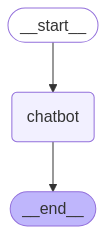

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [10]:
input={"messages":["hi, my name is Rovidu"]}

In [11]:
app.invoke(input)


{'messages': [HumanMessage(content='hi, my name is Rovidu', additional_kwargs={}, response_metadata={}, id='67f96a06-967d-4e02-89b0-848d20b8ce12'),
  AIMessage(content="Hi Rovidu! It's nice to meet you. Is there anything I can help you with today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cc94e8aa-467f-49f1-bc41-49cefe6605fc-0', usage_metadata={'input_tokens': 8, 'output_tokens': 24, 'total_tokens': 32, 'input_token_details': {'cache_read': 0}})]}

In [12]:

for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="Hi Rovidu! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-750e121c-6074-476d-87d9-3a57a4354c51-0', usage_metadata={'input_tokens': 8, 'output_tokens': 21, 'total_tokens': 29, 'input_token_details': {'cache_read': 0}})]}




In [13]:
#Adding a tool to the workflow
@tool  
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."



In [14]:
search.invoke("What is the weather in San Francisco?")

"It's 60 degrees and foggy."

In [15]:
search.invoke("What is the weather in sl?")

"It's 90 degrees and sunny."

In [16]:
tools=[search]

In [17]:
tool_node=ToolNode(tools)


In [18]:
llm_with_tool=llm.bind_tools(tools)

In [19]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}


In [20]:
response=call_model({"messages": ["hi how are you?"]})


In [21]:
response

{'messages': [AIMessage(content='I am doing well, thank you for asking. How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b7e8203d-ff45-40cc-813d-487e0acf93f1-0', usage_metadata={'input_tokens': 16, 'output_tokens': 18, 'total_tokens': 34, 'input_token_details': {'cache_read': 0}})]}

In [22]:
response['messages'][-1].tool_calls

[]

In [23]:
response2=call_model({"messages": ["what is a weather in India?"]})


In [24]:
response2

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-67a38f62-a123-4505-a46a-52c4a27e87fd-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'c85058d4-19a6-40b1-8214-219e71417135', 'type': 'tool_call'}], usage_metadata={'input_tokens': 18, 'output_tokens': 5, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})]}

In [25]:
response2['messages'][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': 'c85058d4-19a6-40b1-8214-219e71417135',
  'type': 'tool_call'}]

In [32]:
from langgraph.graph import StateGraph,MessagesState, START, END 

def router_function(state: MessagesState) -> Literal["tools",END]: 
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END


In [35]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()


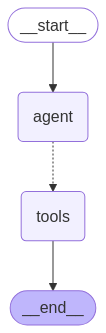

In [36]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))